In [1]:
# I wouldn't recommend running this notebook in Binder. There will be import errors. 
import geopandas as gpd
import pandas as pd
import osmnx as ox
import networkx as nx
from pyproj import CRS

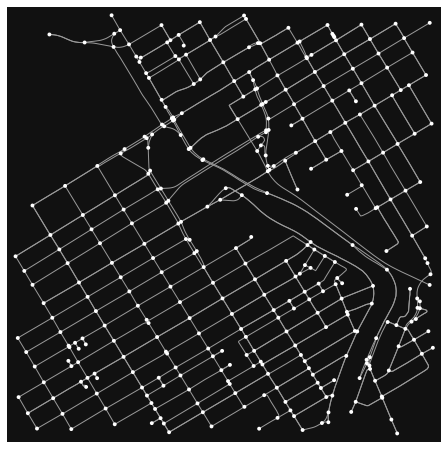

In [2]:
# Plot graph
# Network types are 'walk', 'bike', 'drive_service', 'drive', 'all', 'all_private'
graph = ox.graph_from_address('Ottawa, Canada', network_type='drive')
fig, ax = ox.plot_graph(graph)

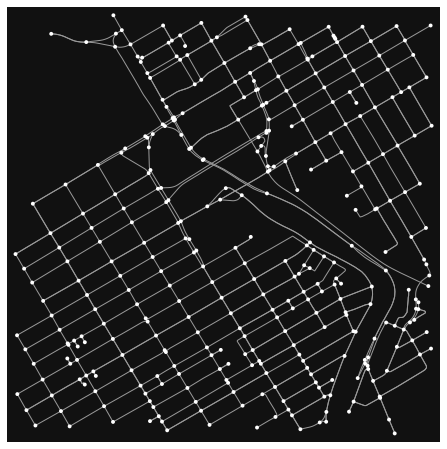

In [3]:
# Project graph
graph_proj = ox.project_graph(graph)
fig, ax = ox.plot_graph(graph_proj)

In [4]:
# Retrieve only edges from the graph
edges = ox.graph_to_gdfs(graph, nodes=False, edges=True)

# Get Edges and Nodes
nodes_proj, edges_proj = ox.graph_to_gdfs(graph_proj, nodes=True, edges=True)
CRS(edges_proj.crs).to_epsg()

32618

In [5]:
# Calculate network statistics
stats = ox.basic_stats(graph_proj, circuity_dist='euclidean')

# Get the Convex Hull of the network to calculate extended statistics 
convex_hull = edges_proj.unary_union.convex_hull

# Calculate the area
area = convex_hull.area

# Calculate statistics with density information
stats = ox.basic_stats(graph_proj, area=area)
extended_stats = ox.extended_stats(graph_proj, ecc=True, cc=True)

# Add extened statistics to the basic statistics
for key, value in extended_stats.items():
    stats[key] = value

# Convert the dictionary to a Pandas series for a nicer output
pd.Series(stats)

n                                                                                    354
m                                                                                    814
k_avg                                                                            4.59887
intersection_count                                                                   330
streets_per_node_avg                                                             3.32768
streets_per_node_counts                       {0: 0, 1: 24, 2: 10, 3: 150, 4: 166, 5: 4}
streets_per_node_proportion            {0: 0.0, 1: 0.06779661016949153, 2: 0.02824858...
edge_length_total                                                                85563.6
edge_length_avg                                                                  105.115
street_length_total                                                              58335.6
street_length_avg                                                                106.065
street_segments_count

In [6]:
# Get the Convex Hull of the network
convex_hull = edges_proj.unary_union.convex_hull

# Centroid
centroid = convex_hull.centroid

In [7]:
# Add first occurence of a highway id and have it indexable
tests = nodes_proj.groupby('highway', as_index=False).first()

new_nodes_proj = []
for index, row in nodes_proj.iterrows():
    new_nodes_proj.append(row)


# Get the x coordinates of the nodes
# Can also use iloc[] to index
nodes_proj['x'] = nodes_proj["x"].astype(float)

# Retrieve the maximum x value (i.e. the most eastern)
#maxx = nodes_proj['x'].max()
# Min would be the most western
#maxx = nodes_proj['x'].min()

# Find shortest path to the first crossing
maxx = new_nodes_proj[0].x

In [8]:
# Retrieve the node that is the most eastern one and get the Shapely Point geometry out of it
target = nodes_proj.loc[nodes_proj['x']==maxx, 'geometry'].values[0]

# Get origin x and y coordinates
orig_xy = (centroid.y, centroid.x)

# Get target x and y coordinates
target_xy = (target.y, target.x)

# Find the node in the graph that is closest to the origin point (here, we want to get the node id)
orig_node = ox.get_nearest_node(graph_proj, orig_xy, method='euclidean')

# Find the node in the graph that is closest to the target point (here, we want to get the node id)
target_node = ox.get_nearest_node(graph_proj, target_xy, method='euclidean')

# Retrieve the rows from the nodes GeoDataFrame
o_closest = nodes_proj.loc[orig_node]
t_closest = nodes_proj.loc[target_node]

# Create a GeoDataFrame from the origin and target points
od_nodes = gpd.GeoDataFrame([o_closest, t_closest], geometry='geometry', crs=nodes_proj.crs)

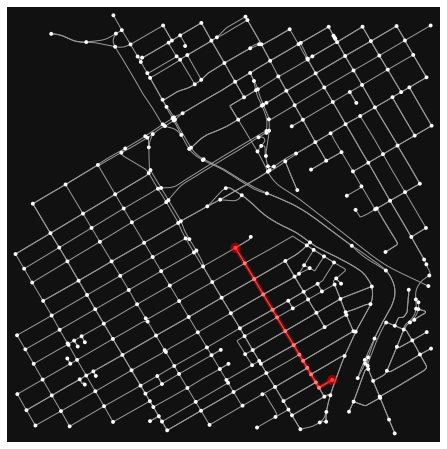

In [9]:
# Calculate the shortest path
route = nx.shortest_path(G=graph_proj, source=orig_node, target=target_node, weight='length')

# Plot the shortest path
fig, ax = ox.plot_graph_route(graph_proj, route)